## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3
7. Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
torch.cuda.device_count()

1

## Dataset, transforms, and visualisation

In [11]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [12]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
num_classes = 10

In [14]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [26]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


In [27]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5               # de-normalize the image
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Resetting the index (224, 224, 3) from (3, 224, 224)
    plt.title(title)
    plt.show()

In [28]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

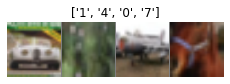

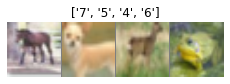

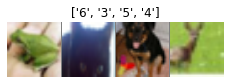

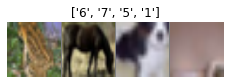

In [29]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16
Award winning ConvNets from 2014 Imagenet ILSVRC challenge



https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [33]:
from torchvision import models           # pytorch model zoo :) 

In [56]:
vgg = models.vgg16_bn()

In [57]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [58]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [59]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [78]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [60]:
list(vgg.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [67]:
from pprint import pprint as pp 

final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
pp(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]


In [68]:
vgg.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [69]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [70]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [71]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [72]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.46
Iteration: 100/3125, Loss: 3.35
Iteration: 200/3125, Loss: 2.38
Iteration: 300/3125, Loss: 2.15
Iteration: 400/3125, Loss: 2.35
Iteration: 500/3125, Loss: 2.26
Iteration: 600/3125, Loss: 2.29
Iteration: 700/3125, Loss: 2.28
Iteration: 800/3125, Loss: 2.29
Iteration: 900/3125, Loss: 2.21
Iteration: 1000/3125, Loss: 2.18
Iteration: 1100/3125, Loss: 2.31
Iteration: 1200/3125, Loss: 2.54
Iteration: 1300/3125, Loss: 3.56
Iteration: 1400/3125, Loss: 2.37
Iteration: 1500/3125, Loss: 2.47
Iteration: 1600/3125, Loss: 2.22
Iteration: 1700/3125, Loss: 2.27
Iteration: 1800/3125, Loss: 2.30
Iteration: 1900/3125, Loss: 2.27
Iteration: 2000/3125, Loss: 2.27
Iteration: 2100/3125, Loss: 2.30
Iteration: 2200/3125, Loss: 2.30
Iteration: 2300/3125, Loss: 2.26
Iteration: 2400/3125, Loss: 2.29
Iteration: 2500/3125, Loss: 2.40
Iteration: 2600/3125, Loss: 2.25
Iteration: 2700/3125, Loss: 2.10
Iteration: 2800/3125, Loss: 2.28
Iteration: 2900/3125, Loss: 2.29
Iteration: 3000/3125, 

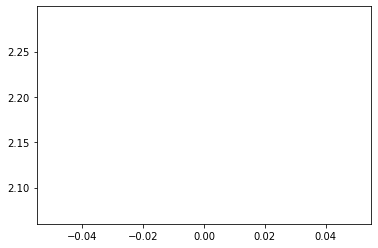

In [73]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

### Freeze layers of Convolutional Operations

In [74]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [75]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [76]:
for param in vgg.parameters():
    param.requires_grad = False

In [77]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [79]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [80]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.28
Iteration: 100/3125, Loss: 2.28
Iteration: 200/3125, Loss: 2.19
Iteration: 300/3125, Loss: 1.85
Iteration: 400/3125, Loss: 1.03
Iteration: 500/3125, Loss: 1.42
Iteration: 600/3125, Loss: 1.78
Iteration: 700/3125, Loss: 2.62
Iteration: 800/3125, Loss: 1.11
Iteration: 900/3125, Loss: 1.59
Iteration: 1000/3125, Loss: 1.46
Iteration: 1100/3125, Loss: 1.50
Iteration: 1200/3125, Loss: 2.64
Iteration: 1300/3125, Loss: 1.23
Iteration: 1400/3125, Loss: 1.42
Iteration: 1500/3125, Loss: 1.75
Iteration: 1600/3125, Loss: 3.09
Iteration: 1700/3125, Loss: 3.16
Iteration: 1800/3125, Loss: 2.69
Iteration: 1900/3125, Loss: 3.22
Iteration: 2000/3125, Loss: 2.09
Iteration: 2100/3125, Loss: 2.39
Iteration: 2200/3125, Loss: 1.77
Iteration: 2300/3125, Loss: 2.15
Iteration: 2400/3125, Loss: 1.28
Iteration: 2500/3125, Loss: 0.91
Iteration: 2600/3125, Loss: 2.51
Iteration: 2700/3125, Loss: 1.68
Iteration: 2800/3125, Loss: 1.50
Iteration: 2900/3125, Loss: 2.05
Iteration: 3000/3125, 

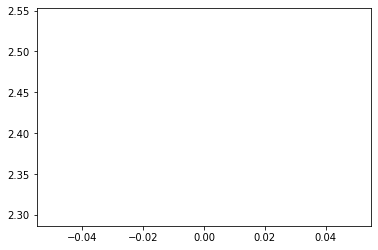

In [81]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

### With model copies

In [82]:
import copy

In [83]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 2.29
Iteration: 0/3125, Loss: 2.29
Min loss 1.63
Min loss 1.48
Min loss 1.09
Min loss 0.82
Iteration: 100/3125, Loss: 1.64
Min loss 0.75
Iteration: 200/3125, Loss: 1.65
Iteration: 300/3125, Loss: 1.95
Iteration: 400/3125, Loss: 1.45
Iteration: 500/3125, Loss: 2.12
Min loss 0.40
Iteration: 600/3125, Loss: 1.63
Iteration: 700/3125, Loss: 2.27
Iteration: 800/3125, Loss: 3.24
Iteration: 900/3125, Loss: 2.52
Iteration: 1000/3125, Loss: 2.07
Iteration: 1100/3125, Loss: 2.25
Iteration: 1200/3125, Loss: 1.75
Iteration: 1300/3125, Loss: 1.16
Iteration: 1400/3125, Loss: 2.02
Iteration: 1500/3125, Loss: 1.75
Iteration: 1600/3125, Loss: 2.39
Iteration: 1700/3125, Loss: 2.95
Iteration: 1800/3125, Loss: 1.16
Iteration: 1900/3125, Loss: 3.25
Iteration: 2000/3125, Loss: 2.75
Iteration: 2100/3125, Loss: 3.88
Iteration: 2200/3125, Loss: 1.86
Iteration: 2300/3125, Loss: 2.29
Iteration: 2400/3125, Loss: 2.39
Iteration: 2500/3125, Loss: 2.38
Iteration: 2600/3125, Loss: 2.03
Iteration: 2700/3125, L

In [84]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

46.996 46.52


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [85]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [86]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
for param in resnet.parameters():
    param.requires_grad = False

In [88]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [89]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [90]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [ ]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

Min loss 2.54
Iteration: 0/3125, Loss: 2.54
Min loss 2.51
Min loss 2.48
Min loss 2.36
Min loss 2.31
Min loss 2.15
Min loss 2.12
Min loss 2.04
Min loss 1.94
Min loss 1.88
Min loss 1.83
Min loss 1.69
Min loss 1.68
Min loss 1.63
Min loss 1.53
Iteration: 100/3125, Loss: 1.75
Min loss 1.50
Min loss 1.42
Min loss 1.37
Min loss 1.23
Iteration: 200/3125, Loss: 1.64
Min loss 1.21
Min loss 1.09
Iteration: 300/3125, Loss: 1.85
Iteration: 400/3125, Loss: 1.41
Min loss 1.01
Min loss 0.94
Iteration: 500/3125, Loss: 1.74
Iteration: 600/3125, Loss: 1.93
Min loss 0.83
Iteration: 700/3125, Loss: 1.03
Min loss 0.76
Min loss 0.74
Iteration: 800/3125, Loss: 1.76
Min loss 0.63
Iteration: 900/3125, Loss: 1.52
Iteration: 1000/3125, Loss: 1.22
Iteration: 1100/3125, Loss: 1.39
Iteration: 1200/3125, Loss: 0.90
Iteration: 1300/3125, Loss: 1.28
Iteration: 1400/3125, Loss: 1.11
Iteration: 1500/3125, Loss: 1.54
Min loss 0.59
Iteration: 1600/3125, Loss: 1.03
Iteration: 1700/3125, Loss: 1.07
Iteration: 1800/3125, Loss

In [92]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

57.08 56.36


## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [93]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [94]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [95]:
for param in inception.parameters():
    param.requires_grad = False

In [98]:
list(inception.children())

[BasicConv2d(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 BasicConv2d(
   (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicConv2d(
   (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 MaxPo

In [99]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [100]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [101]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [102]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [103]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [104]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [105]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [106]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [107]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 2.99
Iteration: 0/3125, Loss: 2.99
Min loss 2.90
Min loss 2.89
Min loss 2.83
Min loss 2.74
Min loss 2.73
Min loss 2.70
Min loss 2.68
Min loss 2.64
Min loss 2.64
Min loss 2.47
Iteration: 100/3125, Loss: 2.73
Min loss 2.45
Min loss 2.36
Min loss 2.29
Min loss 2.29
Iteration: 200/3125, Loss: 2.31
Min loss 2.27
Min loss 2.24
Min loss 2.18
Min loss 2.10
Iteration: 300/3125, Loss: 2.14
Min loss 2.04
Min loss 1.90
Min loss 1.78
Iteration: 400/3125, Loss: 2.27
Min loss 1.69
Iteration: 500/3125, Loss: 2.20
Min loss 1.61
Iteration: 600/3125, Loss: 2.13
Min loss 1.56
Iteration: 700/3125, Loss: 1.88
Iteration: 800/3125, Loss: 1.81
Min loss 1.31
Iteration: 900/3125, Loss: 1.92
Iteration: 1000/3125, Loss: 2.16
Iteration: 1100/3125, Loss: 1.86
Iteration: 1200/3125, Loss: 2.06
Iteration: 1300/3125, Loss: 1.61
Min loss 1.25
Iteration: 1400/3125, Loss: 1.68
Min loss 1.23
Iteration: 1500/3125, Loss: 2.04
Iteration: 1600/3125, Loss: 2.06
Min loss 1.16
Iteration: 1700/3125, Loss: 2.12
Min loss 1.1

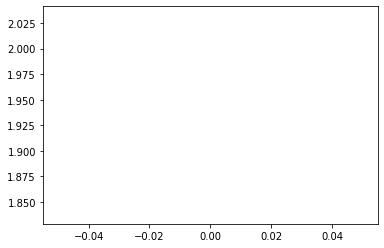

In [108]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [109]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

47.304 47.06


## Exercises

1. Structure the above code into a series of functions and then call each model

2. Try out different hyperparameter combinations and try to achieve published results on different networks

3. Try out the CIFAR100 and STL10 datasets

4. Try out another model - SqueezeNet

5. Try training multiple layers and not just the last one